# 1d-signal data augmentation for regression
GitHub repository: https://github.com/fdesmond/seme-ts

Related paper: https://hal.archives-ouvertes.fr/hal-03211100

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# ml functions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# tsmall module
from tsmall import mdfaug
from utils import run_knn, repeat_augmentation_and_get_statistics, quantile_based_augmentation

## Exploratory data analysis and feature engineering

In [2]:
energy = pd.read_csv('energy_data.csv', parse_dates=['date'])
energy.set_index('date', inplace=True)

# most important columns, Appliances put as last column
ts_index = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Tdewpoint', 'Appliances']

# consider a part of the whole energy dataset
obs_len =  len(energy) #5*7*24*6 
data_A = energy[ts_index].iloc[:obs_len].copy()    

# show dataset dimensions
print('energy dataset size: \t {}'.format(energy.shape) + '\n' +\
      'data_A size: \t \t {}'.format(data_A.shape))

energy dataset size: 	 (19735, 28)
data_A size: 	 	 (19735, 25)


Following the most important variable in Fig.11: **the number of seconds from midnight for each day (NSM)**, and variable **day_of_week**, we construct the equivelant two variables: **daytime ($t_d$)**, **dayofweek ($t_w$)**. We treat these two variables as continuous in the following models even though they are quantized.   

In [3]:
# Add temporal variables
data_A['daytime'] = data_A.index.hour + data_A.index.minute/60 #take values of the minutes from the midnight 
data_A['dayofweek'] = data_A.index.dayofweek #take values 0,1,...,6
#data_A['month'] = data_A.index.month

In the paper, they use only the first order of time $t$ as regressor. Thus for all linear models, they consider only the linear dependency of response and regressor variables time. However, from the following plots, we can see this dependency is nonlinear, which is *periodic on daily basis* (there is linear part which is with respect to month, for the moment we don't consider this aspect since this is not the main concern of the work). 

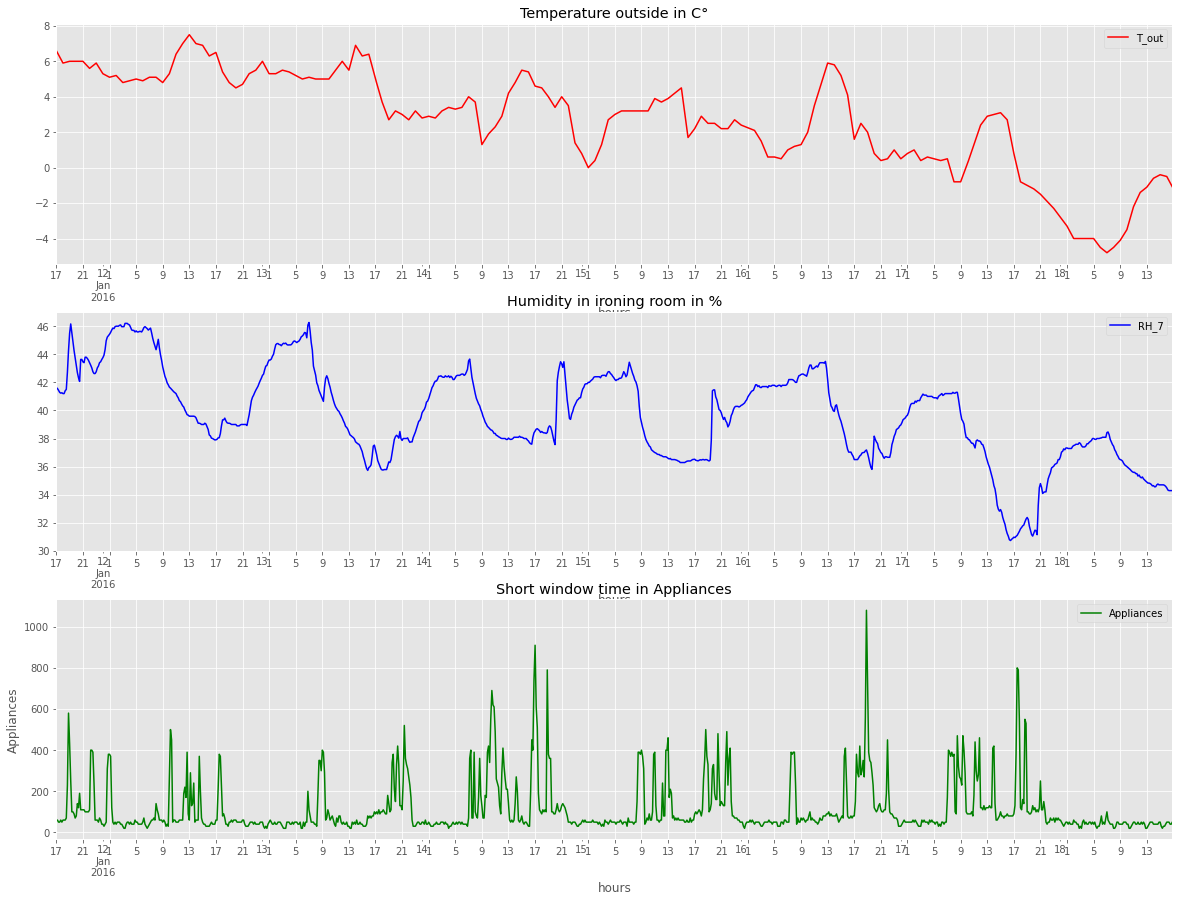

In [4]:
xtick_ind = np.arange(start = 0,stop=1008,step = 24,dtype = np.int32)

fig, ax = plt.subplots(figsize=[20,15], nrows=3, ncols=1)
pd.DataFrame(data_A.T_out.iloc[:1008]).plot(ax=ax[0], title='Temperature outside in C°', color='r')
pd.DataFrame(data_A.RH_7.iloc[:1008]).plot(ax=ax[1], title='Humidity in ironing room in %', color='b')
pd.DataFrame(data_A.Appliances.iloc[:1008]).plot(color='g', title='Short window time in Appliances', ax=ax[2]).set(ylabel='Appliances')

for i in range(3):
    _=ax[i].set_xticks(data_A.index.values[xtick_ind])
    _=ax[i].set_xticklabels(labels = data_A.index.hour[xtick_ind])
    _=ax[i].set_xlabel("hours")

### Nonlinear trend of time series

Thus, we use a polynomial $p(t_w, t_d, m)$ as regressor to capture the nonlinear trend, which is motivated from the polynomial regression. The $m$ is set as $12$. For example, in the following plot, we show the approximated trend curve by polynomial regression using $p(t_w, t_d, 12)$ and `ytrain_A` without other regressors. NB: other basis functions can also be used as regressor varible e.g. *Chebyshev polynomials*.

In [5]:
np.random.seed(23)

In [6]:
# train-test-split of data_A
y_A = data_A.Appliances
X_A = data_A.drop(columns='Appliances')
xtrain_A, xtest_A, ytrain_A, ytest_A = train_test_split(X_A, y_A, test_size=0.25)

In [7]:
from sklearn.preprocessing import PolynomialFeatures 
poly = PolynomialFeatures(degree = 12) 
trend = LinearRegression().fit(poly.fit_transform(xtrain_A[['daytime', 'dayofweek']]), ytrain_A)

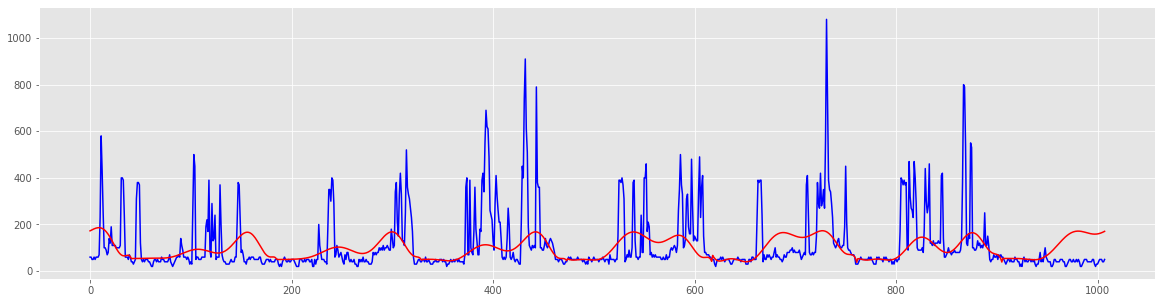

In [8]:
plt.rcParams['figure.figsize'] = [20, 5]
data_A_trend = trend.predict(poly.fit_transform(data_A[['daytime', 'dayofweek']].iloc[:7*24*6]))

plt.plot(range(7*24*6), data_A.Appliances.iloc[:7*24*6], color = 'blue') 
plt.plot(range(7*24*6), data_A_trend, color = 'red') 

We compare two sets of regressor variables (with and without considering the trend) for the models: LM, KNN, RF, GBM.

In [9]:
# scaling
ss_A = StandardScaler()

sxtrain_A = ss_A.fit_transform(xtrain_A.drop(columns=['daytime', 'dayofweek'], inplace=False))
sxtest_A = ss_A.transform(xtest_A.drop(columns=['daytime', 'dayofweek'], inplace=False))

sxtrain_A_t = ss_A.fit_transform(np.append(xtrain_A.drop(columns=['daytime', 'dayofweek'], inplace=False), poly.fit_transform(xtrain_A[['daytime', 'dayofweek']]), axis = 1))
sxtest_A_t = ss_A.transform(np.append(xtest_A.drop(columns=['daytime', 'dayofweek'], inplace=False), poly.fit_transform(xtest_A[['daytime', 'dayofweek']]), axis = 1))

In [10]:
# fitting
# RF
model_A = RandomForestRegressor().fit(sxtrain_A, ytrain_A)
ypred_A = model_A.predict(sxtest_A)

model_A_t = RandomForestRegressor().fit(sxtrain_A_t, ytrain_A)
ypred_A_t = model_A_t.predict(sxtest_A_t)

# metrics
rmse_AA = mean_squared_error(ytest_A, ypred_A, squared=False)
R2_AA = r2_score(ytest_A, ypred_A)

rmse_AA_t = mean_squared_error(ytest_A, ypred_A_t, squared=False)
R2_AA_t = r2_score(ytest_A, ypred_A_t)

print('Random Forest:')
display('model_A on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))
display('model_A(with trend) on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA_t,R2_AA_t))


# LM
model_A = LinearRegression().fit(sxtrain_A, ytrain_A)
ypred_A = model_A.predict(sxtest_A)

model_A_t = LinearRegression().fit(sxtrain_A_t, ytrain_A)
ypred_A_t = model_A_t.predict(sxtest_A_t)

# metrics
rmse_AA = mean_squared_error(ytest_A, ypred_A, squared=False)
R2_AA = r2_score(ytest_A, ypred_A)

rmse_AA_t = mean_squared_error(ytest_A, ypred_A_t, squared=False)
R2_AA_t = r2_score(ytest_A, ypred_A_t)

print('Linear Regression:')
display('model_A on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))
display('model_A(with trend) on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA_t,R2_AA_t))


# KNN
model_A = run_knn(X_train=sxtrain_A, Y_train=ytrain_A)
ypred_A = model_A.predict(sxtest_A)

model_A_t = run_knn(X_train=sxtrain_A_t, Y_train=ytrain_A)
ypred_A_t = model_A_t.predict(sxtest_A_t)

# metrics
rmse_AA = mean_squared_error(ytest_A, ypred_A, squared=False)
R2_AA = r2_score(ytest_A, ypred_A)

rmse_AA_t = mean_squared_error(ytest_A, ypred_A_t, squared=False)
R2_AA_t = r2_score(ytest_A, ypred_A_t)

print('k-Nearest Neighbour:')
display('model_A on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))
display('model_A(with trend) on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA_t,R2_AA_t))


# GBM
model_A = GradientBoostingRegressor().fit(sxtrain_A, ytrain_A)
ypred_A = model_A.predict(sxtest_A)

model_A_t = GradientBoostingRegressor().fit(sxtrain_A_t, ytrain_A)
ypred_A_t = model_A_t.predict(sxtest_A_t)

# metrics
rmse_AA = mean_squared_error(ytest_A, ypred_A, squared=False)
R2_AA = r2_score(ytest_A, ypred_A)

rmse_AA_t = mean_squared_error(ytest_A, ypred_A_t, squared=False)
R2_AA_t = r2_score(ytest_A, ypred_A_t)

print('Gradient Boosting:')
display('model_A on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))
display('model_A(with trend) on test_A:    MSE {:.2f}    R2 {:.2f}'.format(rmse_AA_t,R2_AA_t))

KeyboardInterrupt: 

The above results imply the trends of response and regressor time series are features more dependent on indivual time series and may not be explained/predicted mutually by the others. Considering the temporal nonlinear function in the regression models amounts to detrend the time series and input the residual part which is more "stationary" into the essential regression models whose performance ususally relies on the *iid assumption* of data.  

Thus, we add the trend into regressor variables for the following analysis.

In [10]:
xtrain_A_t = np.append(xtrain_A.drop(columns=['daytime', 'dayofweek'], inplace=False), poly.fit_transform(xtrain_A[['daytime', 'dayofweek']]), axis = 1)
xtest_A_t = np.append(xtest_A.drop(columns=['daytime', 'dayofweek'], inplace=False), poly.fit_transform(xtest_A[['daytime', 'dayofweek']]), axis = 1)

xtrain_A_t = pd.DataFrame(xtrain_A_t, index = xtrain_A.index)
xtest_A_t = pd.DataFrame(xtest_A_t, index = xtest_A.index)

ts_index.remove('Appliances')
col_indx = ts_index + list(range(91))

xtrain_A_t.rename(columns=lambda x: col_indx[x], inplace=True)
xtest_A_t.rename(columns=lambda x: col_indx[x], inplace=True)

## obtaining `data_B` and `data_C` after `train_test_split`
We now focus on obtaining `data_B` and `data_C` dataframes.

### subsampling for `data_B` 
The train set and the test set for `data_B` are obtained through uniform subsampling from `xtrain_A`, `ytrain_A` and `xtest_A`, `ytest_A` respectively.

In [11]:
np.random.seed(23)

Observations in data_B:	 987
xtrain_B size: 	 	 740
xtest_B size: 	 	 247


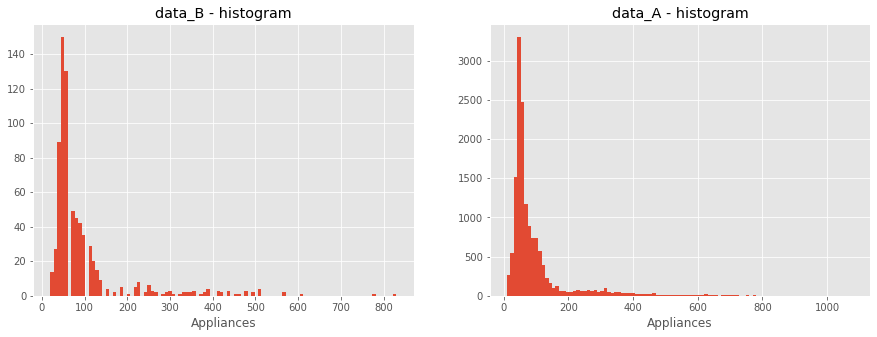

In [12]:
# train-test-split of data_B
p = 0.05 # propotion of data_A in data_B
xtrain_B = xtrain_A_t.sample(frac = p)
ytrain_B = ytrain_A.loc[xtrain_B.index]

xtest_B = xtest_A_t.sample(frac = p)
ytest_B = ytest_A.loc[xtest_B.index]

# visually check that the data_B has a similar Appliances histogram
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=2)
ax[0].set(title='data_B - histogram', xlabel='Appliances')
ax[1].set(title='data_A - histogram', xlabel='Appliances')
ytrain_B.hist(bins=100, ax=ax[0])
ytrain_A.hist(bins=100, ax=ax[1])

# show dataset dimensions
print('Observations in data_B:\t {:.0f}'.format(data_A.shape[0]*p) + '\n' +\
      'xtrain_B size: \t \t {}'.format(xtrain_B.shape[0]) + '\n' +\
      'xtest_B size: \t \t {}'.format(xtest_B.shape[0]))

#### `model_B` and `model_C`
In order to asses the performance of the data augmentation procedure, we subsample `data_A` multiple times and, for each sample `data_B`, we apply data augmentation to retrieve a new `data_C` dataframe. For each `data_B` and `data_C`, two models `model_B` and `model_C` are fit as done for `model_A`.

We compare the mean RMSE and R2 score and we plot a histogram of the results.

##### a quick look on the *categorical* augmentation technique
Contrary to the previous case, we perform data augmentation by slincing `xtrain_B` for the observations which have a similar label and apply the `dfaug()` to each slice.

The general algorithm goes as follow:
1. fix the number of different `y`-class by setting `n_bin`
2. compute the `n_bin` quantile intervals for `y` in `y_train_B_bin`
3. for each quantile interval in `y_train_B_bin`:
   - slice `xtrain_B` and select only the observations `xtrain_B_bin_sample` with label in the interval
   - apply `dfaug()` to `xtrain_B_sample`
   - append the augmented dataframe to `xtrain_C`
4. fit KNN on `xtrain_C` to obtain `model_C`

Observe that this latter technique is breaking the local time-structure of the dataset, but it keeps the categorical structure given by the `y` label.

In [13]:
p: float = 0.05
n_tries: int = 50

# initialize list of results
R2_B = np.zeros(shape=(n_tries, 2))
R2_C = np.zeros(shape=(n_tries, 2))
rmse_B = np.zeros(shape=(n_tries, 2))
rmse_C = np.zeros(shape=(n_tries, 2))

for k in range(n_tries):
    # sample data_B
    xtrain_B = xtrain_A_t.sample(frac=p, random_state=k)
    ytrain_B = ytrain_A.loc[xtrain_B.index]
    xtest_B = xtest_A_t.sample(frac=p, random_state=k)
    ytest_B = ytest_A.loc[xtest_B.index]

    train_C: pd.DataFrame = quantile_based_augmentation(
        xtrain_B,
        ytrain_B,
        n_bins=9
    )
    ytrain_C = train_C[train_C.columns[-1]]
    xtrain_C = train_C[train_C.columns[:-1]]

    # scaling
    ss_B = StandardScaler()
    sxtrain_B = ss_B.fit_transform(xtrain_B)
    sxtest_B = ss_B.transform(xtest_B)
    ss_C = StandardScaler()
    sxtrain_C = ss_C.fit_transform(xtrain_C)

    # model fitting
    model_B = run_knn(X_train=sxtrain_B, Y_train=ytrain_B)
    model_C = run_knn(X_train=sxtrain_C, Y_train=ytrain_C)

    # save performances
    R2_B[k, 0] = r2_score(ytest_B, model_B.predict(sxtest_B))
    rmse_B[k, 0] = mean_squared_error(ytest_B, model_B.predict(sxtest_B), squared=False)
    R2_B[k, 1] = r2_score(ytest_A, model_B.predict(sxtest_A_t))
    rmse_B[k, 1] = mean_squared_error(ytest_A, model_B.predict(sxtest_A_t), squared=False)
    R2_C[k, 0] = r2_score(ytest_B, model_C.predict(sxtest_B))
    rmse_C[k, 0] = mean_squared_error(ytest_B, model_C.predict(sxtest_B), squared=False)
    R2_C[k, 1] = r2_score(ytest_A, model_C.predict(sxtest_A_t))
    rmse_C[k, 1] = mean_squared_error(ytest_A, model_C.predict(sxtest_A_t), squared=False)

### Results
There is statistical evidence that `model_C` is outperforming `model_B`: not only for different realization of `data_B` and `data_C`, but also by fixing `data_B` and `data_C` and running the two corresponding model on different test sets from `data_A`.

For KNN algorithm, we obtain a fair improvement on the R2 score and -5% on the MSE.

In [14]:
print('-'*100 + '\n' + 'Results ({} times average)'.format(n_tries) + '\n' + '-'*100)
display('model_A on test_A:    RMSE {:.2f}    R2 {:.2f}'.format(rmse_AA,R2_AA))
print('-'*100)
display('model_B on test_B:    RMSE {:.2f}({:.2f})    R2 {:.3f} ({:.3f})'.format(rmse_B[:,0].mean(), rmse_B[:,0].std(), R2_B[:,0].mean(), R2_B[:,0].std()),\
        'model_C on test_B:    RMSE {:.2f}({:.2f})    R2 {:.3f} ({:.3f})'.format(rmse_C[:,0].mean(), rmse_C[:,0].std(), R2_C[:,0].mean(), R2_C[:,0].std()))
print('-'*100)
display('model_B on test_A:    RMSE {:.2f}({:.2f})    R2 {:.3f} ({:.3f})'.format(rmse_B[:,1].mean(), rmse_B[:,1].std(), R2_B[:,1].mean(), R2_B[:,1].std()),\
        'model_C on test_A:    RMSE {:.2f}({:.2f})    R2 {:.3f} ({:.3f})'.format(rmse_C[:,1].mean(), rmse_C[:,1].std(), R2_C[:,1].mean(), R2_C[:,1].std()))
print('-'*100 + '\n' + 'Size of train_C = {:.0f}'.format(xtrain_C.shape[0])\
              + '\n' + 'Size of train_B = {:.0f}'.format(xtrain_B.shape[0]))

'model_B on test_B:    RMSE 100.83(13.74)    R2 0.074 (0.041)'

'model_C on test_B:    RMSE 99.14(13.38)    R2 0.103 (0.061)'

----------------------------------------------------------------------------------------------------


'model_B on test_A:    RMSE 103.52(1.11)    R2 0.071 (0.020)'

'model_C on test_A:    RMSE 101.26(1.10)    R2 0.111 (0.019)'

----------------------------------------------------------------------------------------------------
Size of train_C = 6540
Size of train_B = 740


The use of trend variable is to 
1.make the essential input of regression models more stationary ideally iid. 
a) This will not only help to improve the prediction performance of models, 
b) but also to the data augmentation performance, since if the data_A is more iid, then the sampled dataset(train_A, train_B) is more representive then their noisier version will help to increase the generality of model more.

2.we can claim we are process time series data but not only to 1D signal then

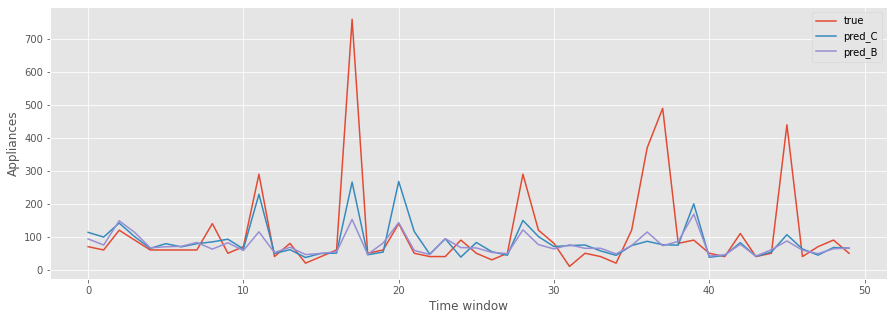

In [15]:
plt.rcParams['figure.figsize'] = [15, 5]
s=1000
i=50
plt.plot(range(i), ytest_A[s:s+i], label = "true")
plt.plot(range(i), model_C.predict(sxtest_A_t[s:s+i]), label = "pred_C")
plt.plot(range(i), model_B.predict(sxtest_A_t[s:s+i]), label = "pred_B")
plt.xlabel('Time window')
plt.ylabel('Appliances')
plt.legend()

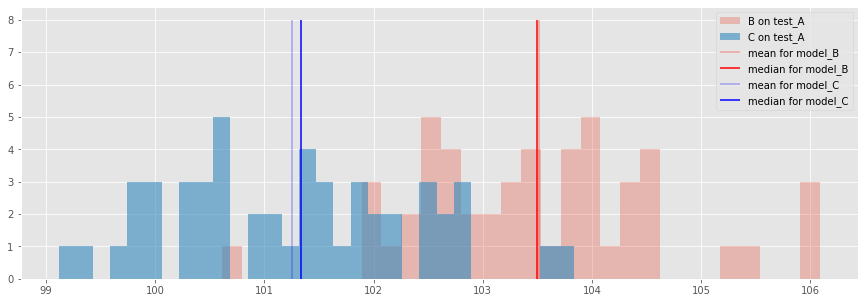

In [16]:
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=1)
#plt.hist(rmse_B[:,0], bins = 50, alpha=.5, label='B on test_B')
plt.hist(rmse_B[:,1], bins = 30, alpha=.3, label='B on test_A')
plt.vlines(rmse_B[:,1].mean(), 0, 8, color='r', alpha=0.3, label='mean for model_B')
plt.vlines(np.median(rmse_B[:,1]), 0, 8, color='r', label='median for model_B')

#plt.hist(rmse_C[:,0], bins = 50, alpha=.5, label='C on test_B')
plt.hist(rmse_C[:,1], bins = 30, alpha=.6, label='C on test_A')
plt.vlines(rmse_C[:,1].mean(), 0, 8, color='b', alpha=0.3, label='mean for model_C')
plt.vlines(np.median(rmse_C[:,1]), 0, 8, color='b', label='median for model_C')

#plt.hist(rmse_star, bins=50, alpha=.3, label='star on test A', color='g')
#plt.title('RMSE histogram on {} different trained models'.format(len(rmse_B[:,1])))
plt.legend()